# 📌 Step 1: Install Required Libraries

In [ ]:
!pip install kaggle --quiet
!pip install tensorflow matplotlib seaborn --quiet

# 📌 Step 2: Upload Your Kaggle API Token
Go to https://www.kaggle.com/settings

Scroll down to “API” and click “Create New API Token”

Upload the kaggle.json file in Colab

In [ ]:
kaggle_api = '/content/sample_data/kaggle.json'

In [ ]:
# Copy Kaggle API Key from Drive to .kaggle/
!mkdir -p ~/.kaggle


In [ ]:
!cp /content/sample_data/kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

# 📌 Step 3: Download FER2013 Dataset from Kaggle

In [ ]:
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 988MB/s]


# 📌 Step 4: Set Up Image Data Loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory
train_dir = "/content/train"
test_dir = "/content/test"

# Create ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of training data for validation
)

# Training generator (80% of train data)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator (20% of train data)
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Test generator (no split needed)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# 📌 Step 5: Build the CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,047 (3.20 MB)

 Trainable params: 839,047 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

# 📌 Step 6: Train the Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.2503 - loss: 1.8199 - val_accuracy: 0.3473 - val_loss: 1.6363
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.3602 - loss: 1.6297 - val_accuracy: 0.4337 - val_loss: 1.5000
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4074 - loss: 1.5246 - val_accuracy: 0.4379 - val_loss: 1.4482
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4341 - loss: 1.4593 - val_accuracy: 0.4673 - val_loss: 1.3922
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4493 - loss: 1.4292 - val_accuracy: 0.4816 - val_loss: 1.3652
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4614 - loss: 1.3948 - val_accuracy: 0.4889 - val_loss: 1.3443
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4759 - loss: 1.3651 - val_accuracy: 0.5037 - val_loss: 1.3135
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4874 - loss: 1.3295 - val_accu

# 📌 Step 7: Evaluate on Test Data


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5158 - loss: 1.5105
Test Accuracy: 0.5648


# 📌 Step 8: Plot Training and Validation Metrics

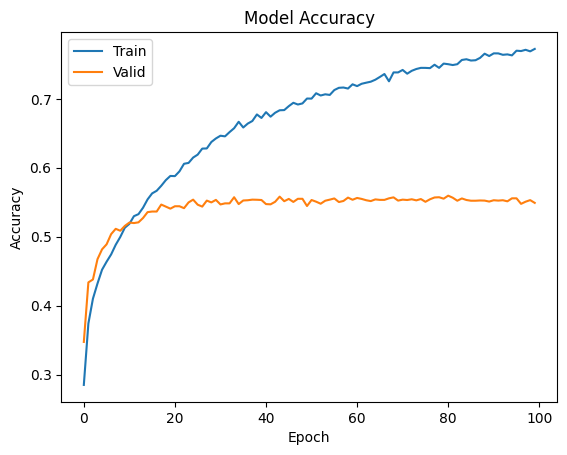

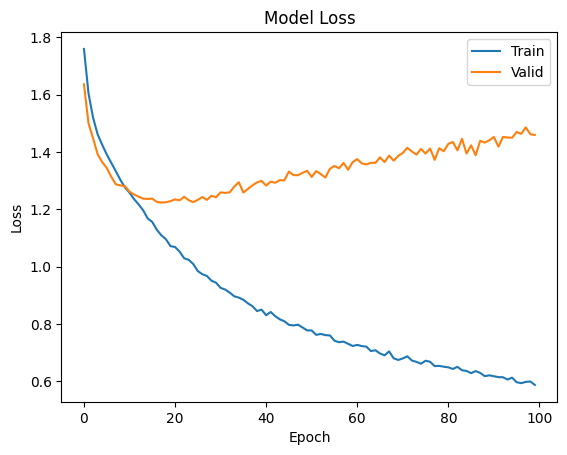

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 📌 Step 9: Inference on a single image

In [ ]:
class_labels = list(train_generator.class_indices.keys())

In [ ]:
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
import os

def predict_emotion(img_path):
    # Get actual class name from file path
    actual_label = os.path.basename(os.path.dirname(img_path))

    # Load and preprocess image
    img = image.load_img(img_path, color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]

    # Display image with actual & predicted label
    plt.imshow(img_array[0].squeeze(), cmap='gray')
    plt.title(f"Actual: {actual_label.capitalize()} | Predicted: {predicted_label.capitalize()}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


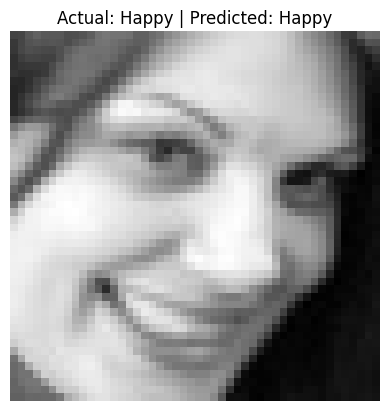

In [ ]:
predict_emotion("/content/test/happy/PrivateTest_13103594.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


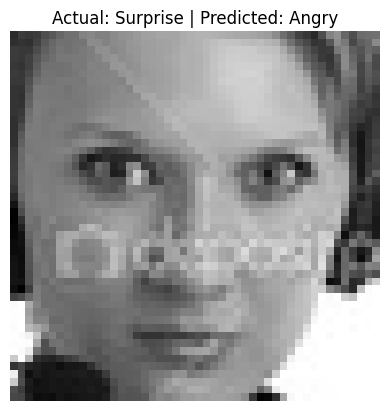

In [ ]:
predict_emotion("/content/test/surprise/PrivateTest_13683211.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


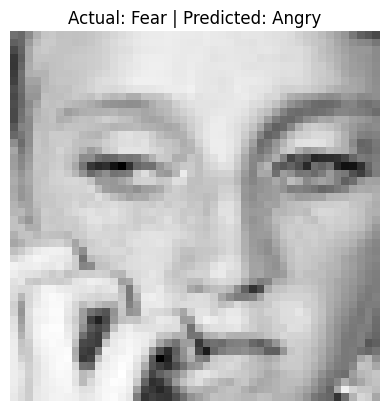

In [ ]:
predict_emotion("/content/test/fear/PrivateTest_11014592.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


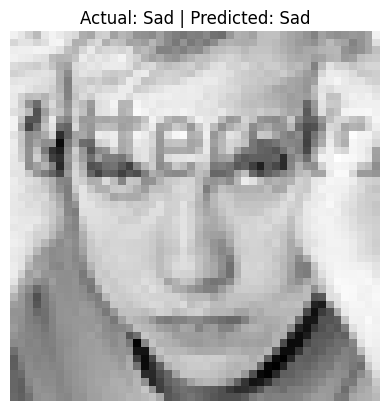

In [ ]:
predict_emotion("/content/test/sad/PrivateTest_10814167.jpg")